# Sumary  

#### Data source
> Kaggle dataset: https://www.kaggle.com/datasets/mcfurland/10-m-beatport-tracks-spotify-audio-features?select=sp_release.csv
- Filter tracks from albums with popularity > 50
- Collect genres and track popularity features with Spotify API
- Merge every feature of interest into a single dataset
- Est. number of observations = 21500

#### Modeling
- Regression: predict track popularity
- Classification: multiclass prediction of genre
- Clustering: group similar tracks and check correlation with genre
- Extract most important features for each model

#### TODO:
- Balance **genres** feature. Extract top genres to reduce number of categories (current amount ~ 156)

- Selecionei os datasets sobre spotify da base de dados do Kaggle
- Não há informação sobre os gêneros musicais dos albuns e popularidades das faixas
- Obs: Generos são disponíveis apenas em albuns, não há classificação por faixa
- Filtrei apenas ids de albuns com popularidade > 50
- Coletei as informações faltantes com a API do Spotify
- Juntei todas as informações em um único dataset

# Data dictionary

- **acousticness [0, 1]** - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.  

- **danceability [0, 1]** - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.  

- **duration_ms** - The duration of the track in milliseconds.  

- **energy [0, 1]** - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.  

- **instrumentalness [0, 1]** - Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.  

- **key [-1, 11]** - The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.  

- **liveness [0, 1]** - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.  

- **loudness** - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.  

- **mode 0 or 1** - Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.  

- **speechiness [0, 1]** - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audiobook, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.  

- **tempo** - The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.  

- **time_signature [3,7]** - An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".  

- **valence [0, 1]** - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

# Exploratory Data Analysis

In [11]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import DataConversionWarning
import plotly.express as px
import plotly.subplots as sp

# Ignore DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

C = '\033[1;34m'
R = '\033[0m'

df = pd.read_csv('data/spotify_data_cleaned.csv')

# Drop unnecessary columns and outliers
df.dropna(subset='genres', inplace=True)

# Cast columns to correct data types
df['genres'] = df['genres'].dropna().apply(lambda x: x[2:-2].split("' '"))

# pd.get_dummies(df['genres'].explode()).groupby(level=0).sum()

df.reset_index(drop=True, inplace=True)
df.head()

,duration_ms,explicit,genres,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,284320,f,[pop],11,0.04870,0.760,0.667,0.0873,0.0,0.0872,-6.962,1.0,0.0430,116.0,4.0,0.9640
1,108493,f,[pop],7,0.03460,0.675,0.768,0.9780,7.0,0.0427,-8.933,1.0,0.0360,138.0,4.0,0.8290
2,152266,f,[pop],7,0.19100,0.270,0.259,0.8680,6.0,0.1170,-14.208,1.0,0.0329,99.0,4.0,0.0471
3,107840,f,[pop],7,0.00398,0.500,0.369,0.9430,0.0,0.0789,-9.998,1.0,0.0478,219.0,4.0,0.5320
4,167993,f,[eletronic],27,0.02280,0.286,0.902,0.6550,5.0,0.3460,-3.514,0.0,0.0378,150.0,4.0,0.1640


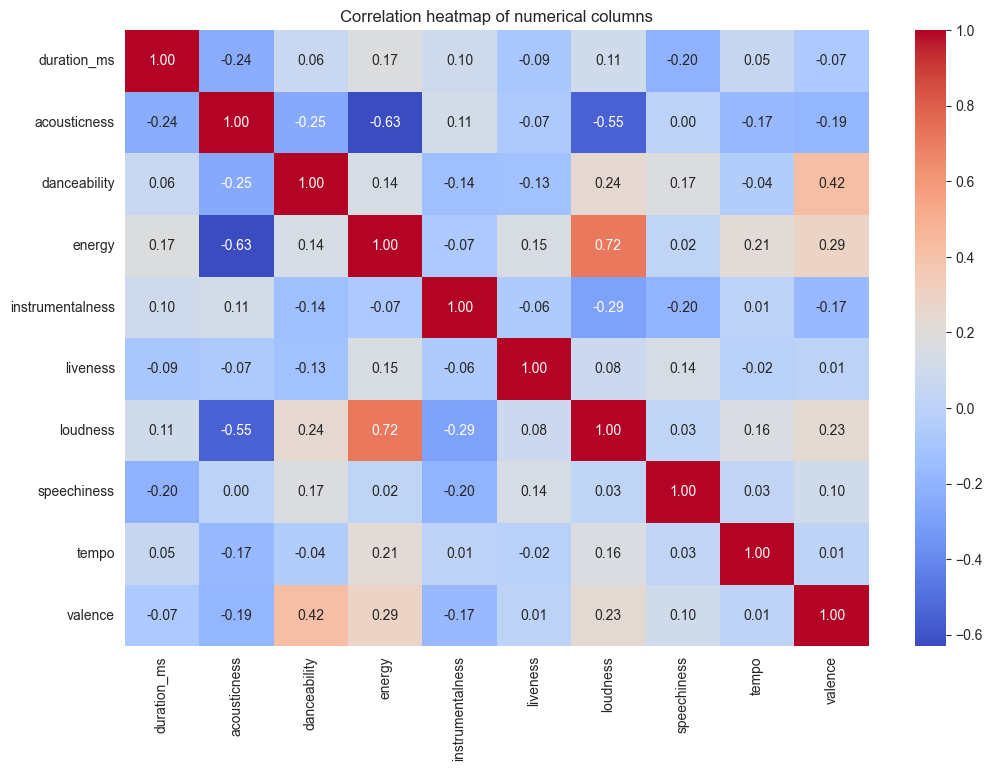

In [2]:
numerical_cols = [
    'duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

# Plot heatmap of numerical columns correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation heatmap of numerical columns')
plt.show()

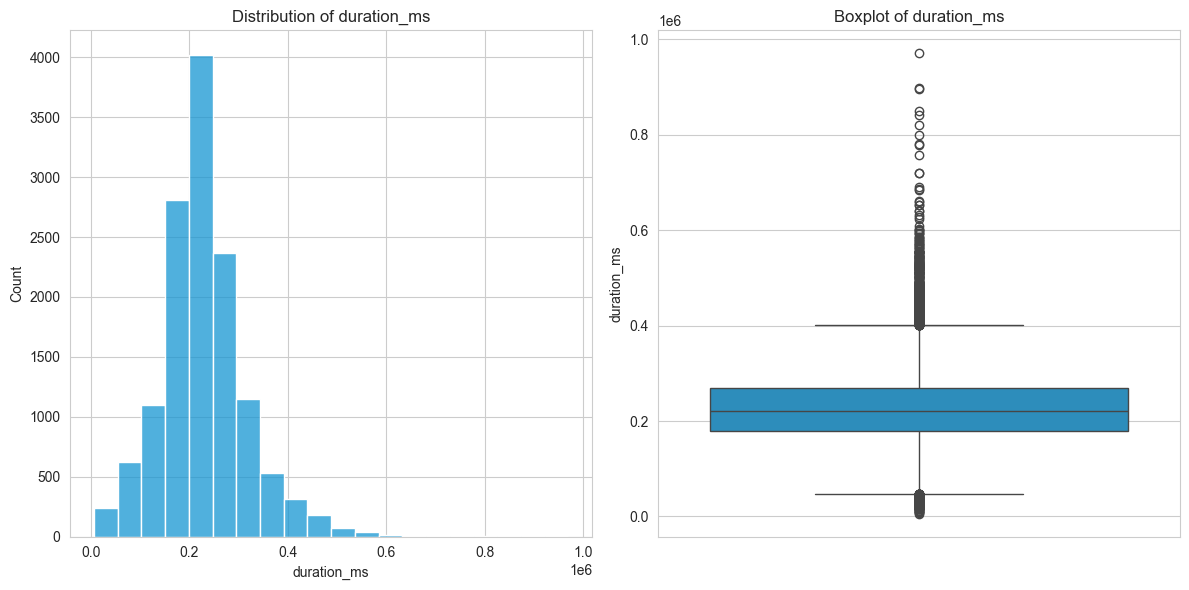

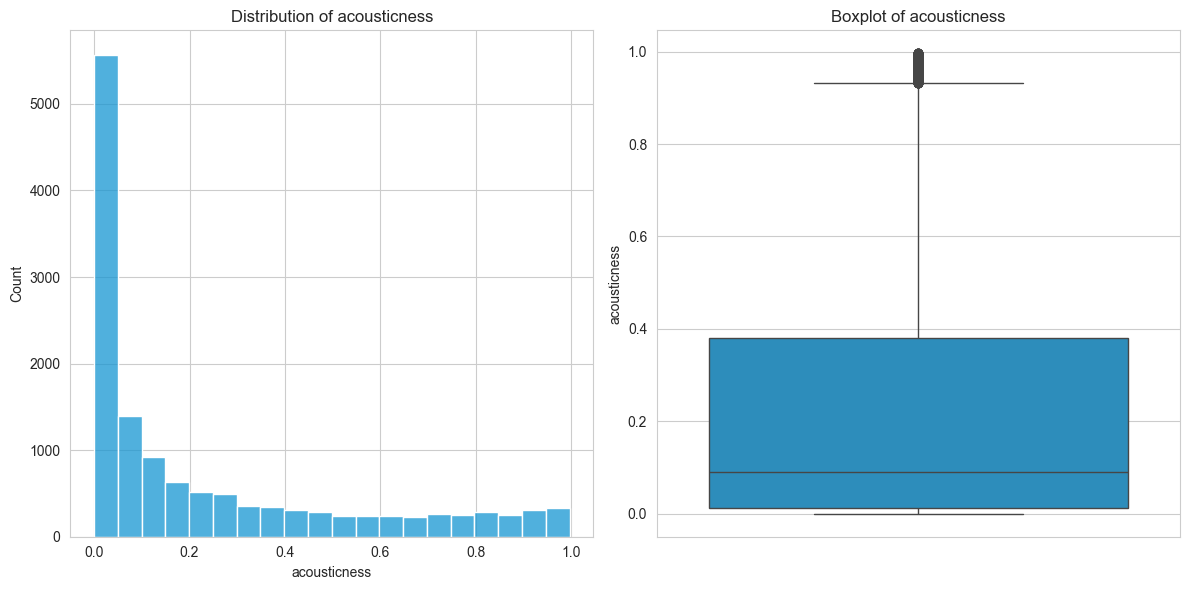

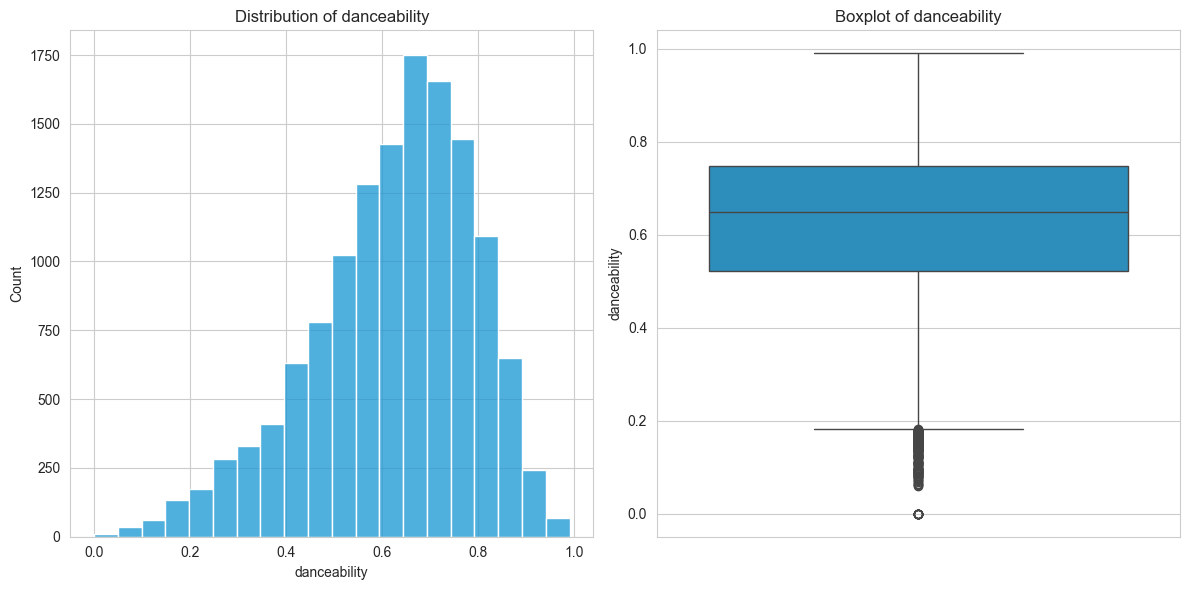

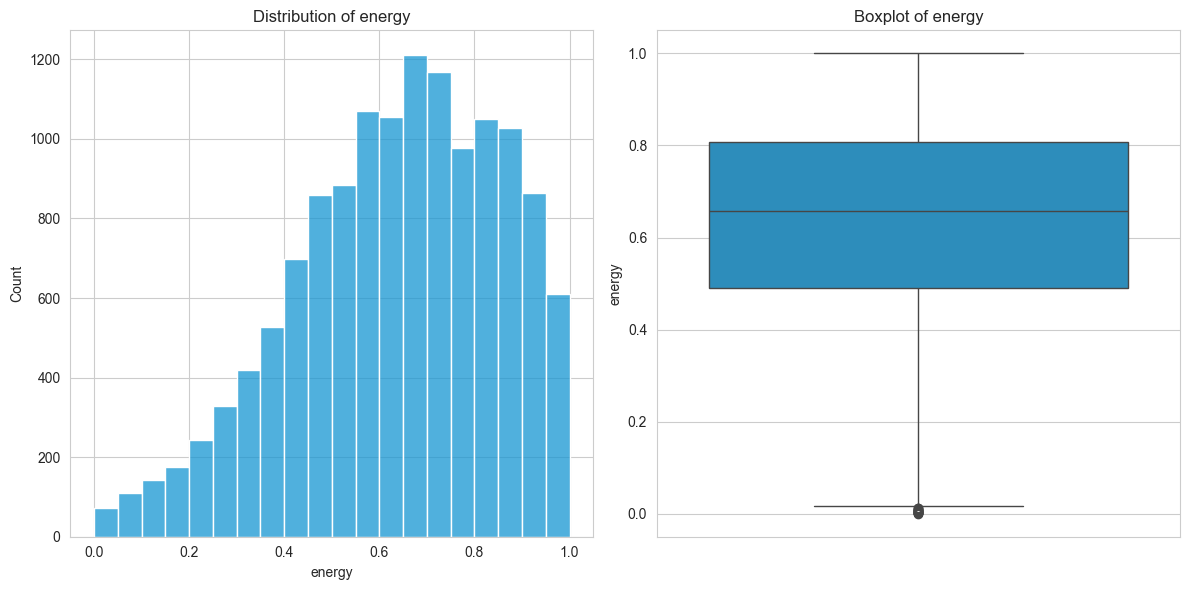

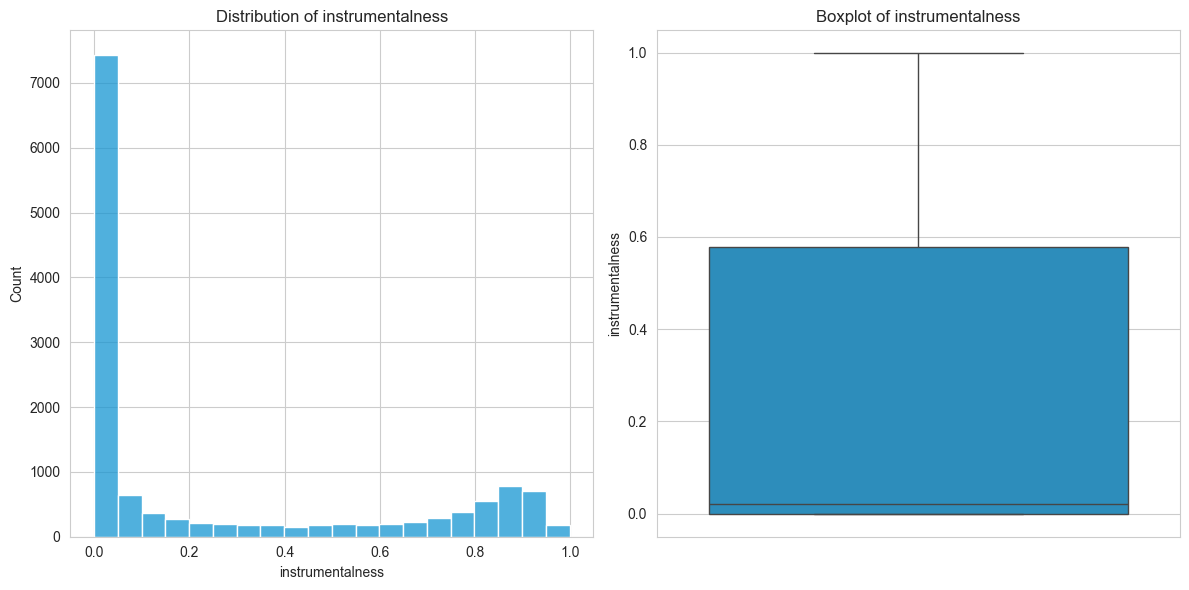

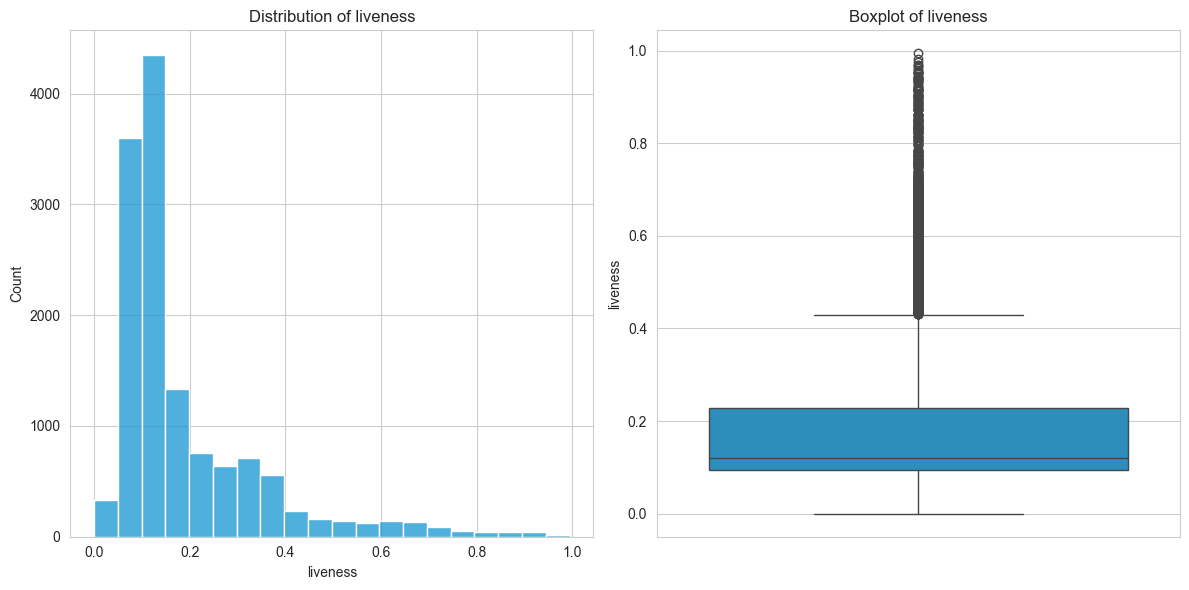

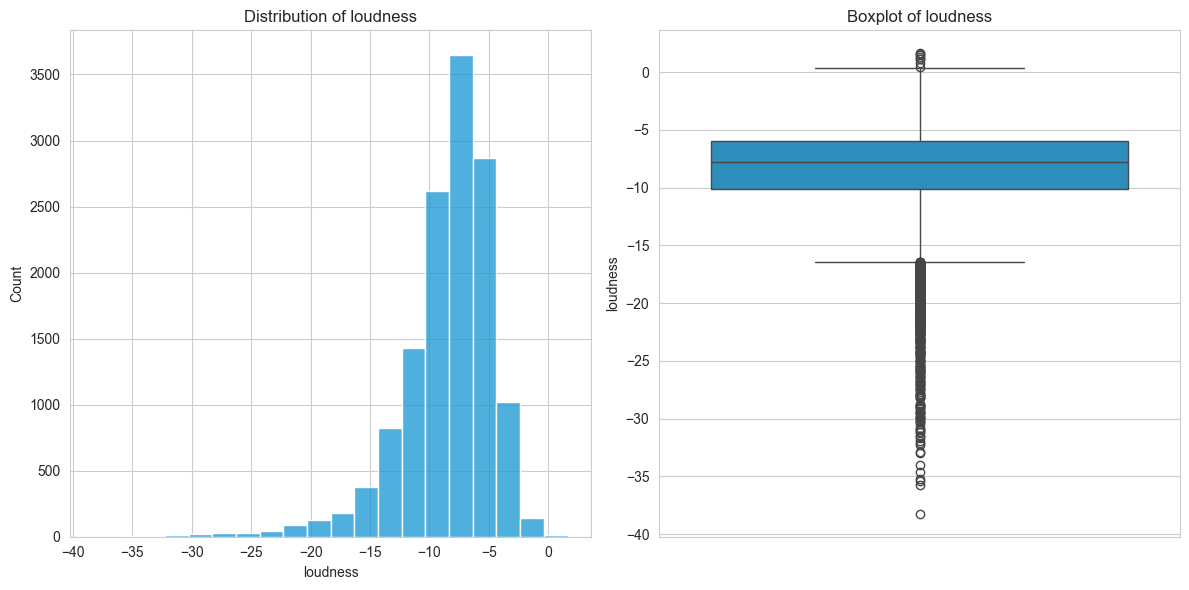

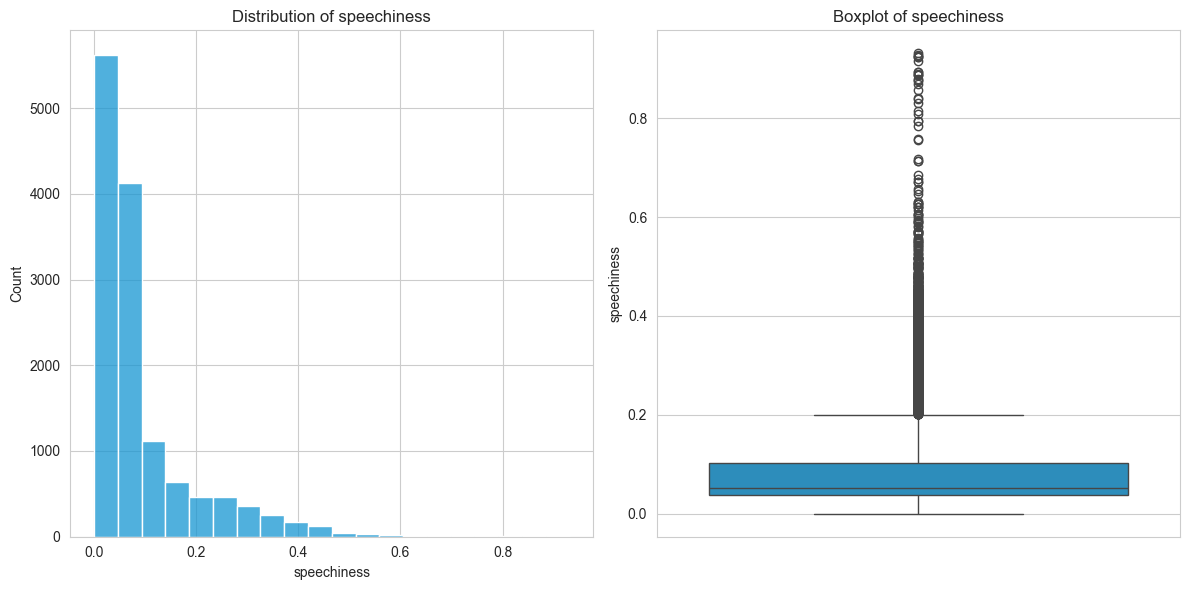

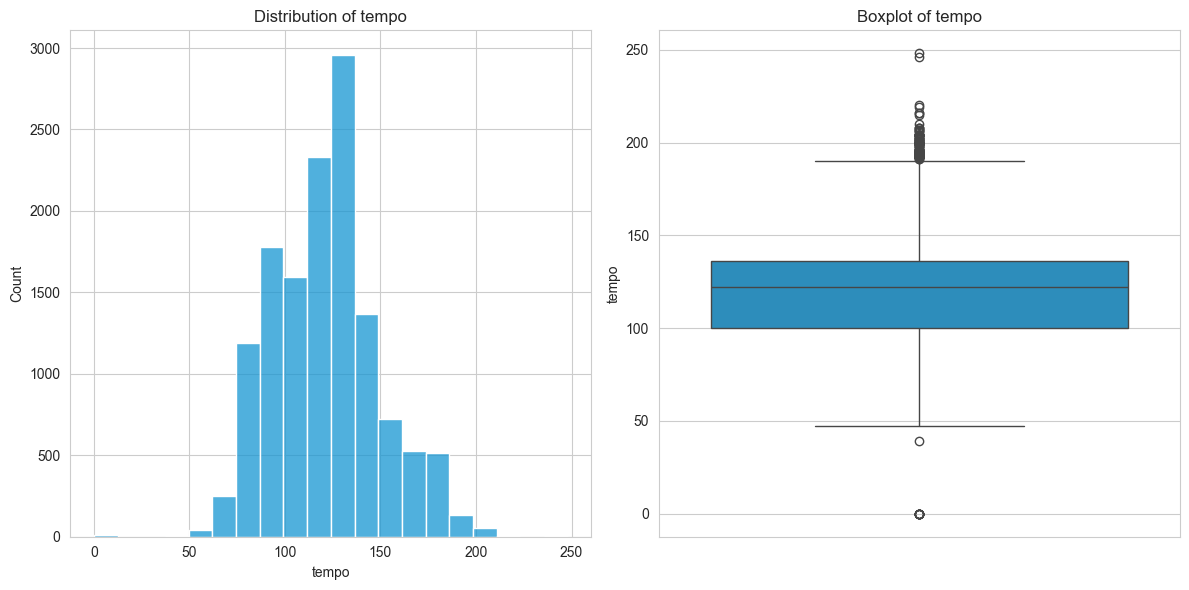

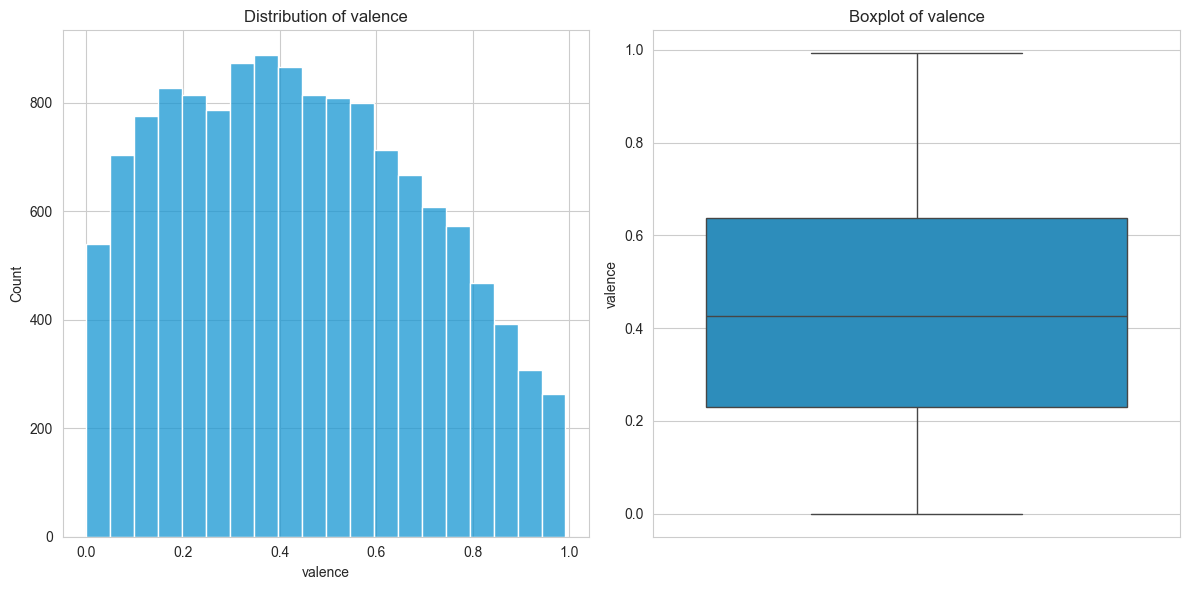

In [3]:
# Plot distribution of every feature of numeric data

for col in numerical_cols:
    if np.issubdtype(df[col].dtype, np.number):
        # Create a figure with 2 subplots: one for the histogram and one for the boxplot
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Add histogram to the first subplot
        sns.histplot(df[col], ax=axs[0], bins=20, color='#1696d2')
        axs[0].set_title(f'Distribution of {col}')

        # Add boxplot to the second subplot
        sns.boxplot(y=df[col], ax=axs[1], color='#1696d2')
        axs[1].set_title(f'Boxplot of {col}')

        # Show the plot
        plt.tight_layout()
        plt.show()

## Feature creation

In [12]:
key_mapping = {
    0: 'C (also B♯, D𝄫)',
    1: 'C♯, D♭ (also B𝄪)',
    2: 'D (also C𝄪, E𝄫)',
    3: 'D♯, E♭ (also F𝄫)',
    4: 'E (also D𝄪, F♭)',
    5: 'F (also E♯, G𝄫)',
    6: 'F♯, G♭ (also E𝄪)',
    7: 'G (also F𝄪, A𝄫)',
    8: 'G♯, A♭',
    9: 'A (also G𝄪, B𝄫)',
    10: 'A♯, B♭ (also C𝄫)',
    11: 'B (also A𝄪, C♭)',
    -1: 'Unknown'
}
df['key_name'] = df['key'].map(key_mapping)

bins = [0, 0.33, 0.66, 1]
labels = ['Low', 'Medium', 'High']

df['acoustic_level'] = pd.cut(df['acousticness'], bins=bins, labels=labels)
df['danceability_level'] = pd.cut(df['danceability'], bins=bins, labels=labels)
df['energy_level'] = pd.cut(df['energy'], bins=bins, labels=labels)
df['loudness_level'] = pd.cut(df['loudness'], bins=3, labels=['Low', 'Medium', 'High'])

bins = [0, 0.5, 1]
labels = ['Vocal', 'Instrumental']
df['instrumental'] = pd.cut(df['instrumentalness'], bins=bins, labels=labels)

bins = [0, 0.8, 1]
labels = ['Studio Recorded', 'Live Performance']
df['live_performance'] = pd.cut(df['liveness'], bins=bins, labels=labels)

bins = [0, 0.33, 0.66, 1]
labels = ['Music', 'Music and Speech', 'Speech']
df['speech_content'] = pd.cut(df['speechiness'], bins=bins, labels=labels)

bins = [0, 0.33, 0.66, 1]
labels = ['Negative', 'Neutral', 'Positive']
df['mood'] = pd.cut(df['valence'], bins=bins, labels=labels)

df['genre_count'] = df['genres'].apply(len)

df['time_signature_name'] = df['time_signature'].astype(str) + '/4'

df['major_mode'] = df['mode'].apply(lambda x: 'Major' if x == 1 else 'Minor')

df['mode'] = df['mode'].astype('category')

df['explicit'] = df['explicit'].map({'f': 0, 't': 1})

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13487 entries, 0 to 13486
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   duration_ms          13487 non-null  int64   
 1   explicit             13487 non-null  int64   
 2   genres               13487 non-null  object  
 3   popularity           13487 non-null  int64   
 4   acousticness         13487 non-null  float64 
 5   danceability         13487 non-null  float64 
 6   energy               13487 non-null  float64 
 7   instrumentalness     13487 non-null  float64 
 8   key                  13487 non-null  float64 
 9   liveness             13487 non-null  float64 
 10  loudness             13487 non-null  float64 
 11  mode                 13487 non-null  category
 12  speechiness          13487 non-null  float64 
 13  tempo                13487 non-null  float64 
 14  time_signature       13487 non-null  float64 
 15  valence            

## Multi-label target ditribution

In [6]:
pd.get_dummies(df['genres'].explode()).groupby(level=0).sum()

,eletronic,hip hop,pop,r&b,rap,rock
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
13482,0,0,1,0,0,1
13483,0,0,1,0,0,1
13484,1,0,1,0,0,0
13485,1,0,1,0,0,0


Target labels: ['pop' 'eletronic' 'r&b' 'hip hop' 'rock' 'rap']


<Axes: xlabel='genres'>

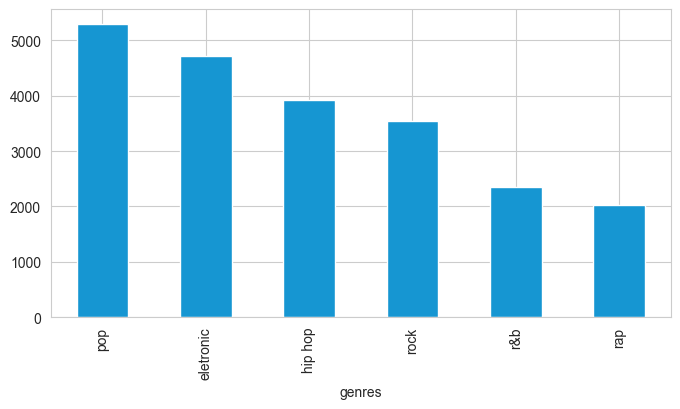

In [13]:
class_labels = df['genres'].explode().unique()
print('Target labels:', class_labels)
df['genres'].explode().value_counts().plot(kind='bar', figsize=(8, 4), color='#1696d2')

# Clasification problem
> predict track genre

## Baseline Model

Cross-validation scores: [0.32283173 0.30504077 0.33036707 0.3129403  0.31887282]
Average cross-validation score: 0.32
              precision    recall  f1-score   support

         pop       0.58      0.58      0.58       962
   eletronic       0.59      0.57      0.58       787
         r&b       0.58      0.59      0.58      1072
     hip hop       0.34      0.35      0.35       475
        rock       0.55      0.51      0.53       408
         rap       0.53      0.56      0.54       705

   micro avg       0.55      0.55      0.55      4409
   macro avg       0.53      0.53      0.53      4409
weighted avg       0.55      0.55      0.55      4409
 samples avg       0.49      0.49      0.49      4409



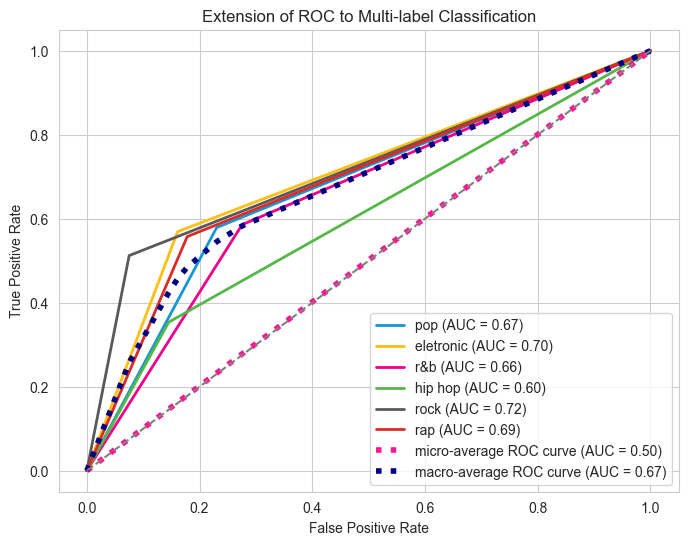

In [14]:
# Classification: predict track genre
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

X = df.drop(columns=['genres']).copy()
y = pd.get_dummies(df['genres'].explode()).groupby(level=0).sum()
assert X.shape[0] == y.shape[0]

numerical_variables = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_variables = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_variables),
    ('cat', categorical_pipeline, categorical_variables)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean():.2f}")

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Metrics
print(classification_report(y_test, y_pred, target_names=class_labels, zero_division=0))

from src.utils import plot_roc_auc_multilabel

plot_roc_auc_multilabel(y_test.values, model.predict_proba(X_test), class_labels)

## Fine tunning

In [9]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameters for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Define KFold cross-validation
kf = KFold(n_splits=5)

# Create a base model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Fit the model
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kf,
    n_jobs=-1,
    verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

# Save model
joblib.dump(grid_search.best_estimator_, 'models/random_forest_params.pkl')

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


['models/random_forest_params.pkl']

              precision    recall  f1-score   support

         pop       0.77      0.48      0.59       962
   eletronic       0.79      0.50      0.61       787
         r&b       0.76      0.52      0.62      1072
     hip hop       0.86      0.04      0.08       475
        rock       0.77      0.41      0.54       408
         rap       0.76      0.47      0.58       705

   micro avg       0.77      0.44      0.56      4409
   macro avg       0.79      0.40      0.50      4409
weighted avg       0.78      0.44      0.54      4409
 samples avg       0.42      0.36      0.38      4409



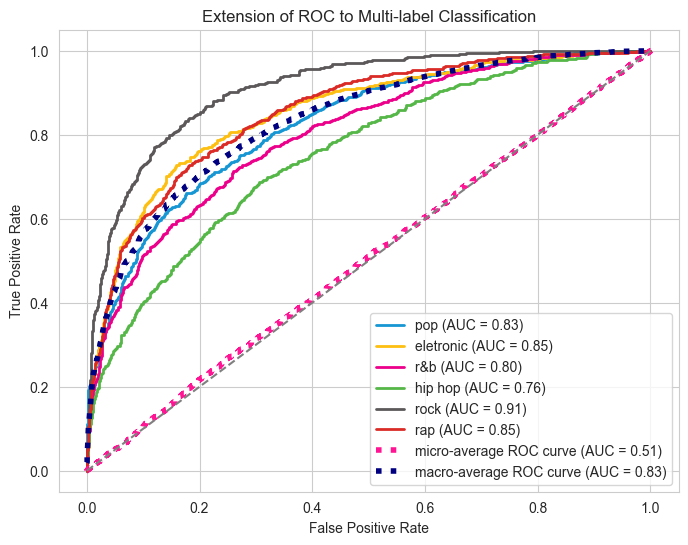

In [15]:
# Get the best parameters
pipeline = joblib.load('models/rfc_pipeline.pkl')

pipeline.fit(X_train, y_train)

# Metrics
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_labels, zero_division=0))
plot_roc_auc_multilabel(y_test.values, pipeline.predict_proba(X_test), class_labels)

# Regression problem
> predict track popularity

## Baseline Model

X shape: (24090, 1003)
y shape: (24090,)


C:\Users\joaob\PycharmProjects\SCC5948_Ver4_Turma3_2024\.venv\lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\joaob\PycharmProjects\SCC5948_Ver4_Turma3_2024\.venv\lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\joaob\PycharmProjects\SCC5948_Ver4_Turma3_2024\.venv\lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Mean squared error: 186.89
R2 score: 0.35


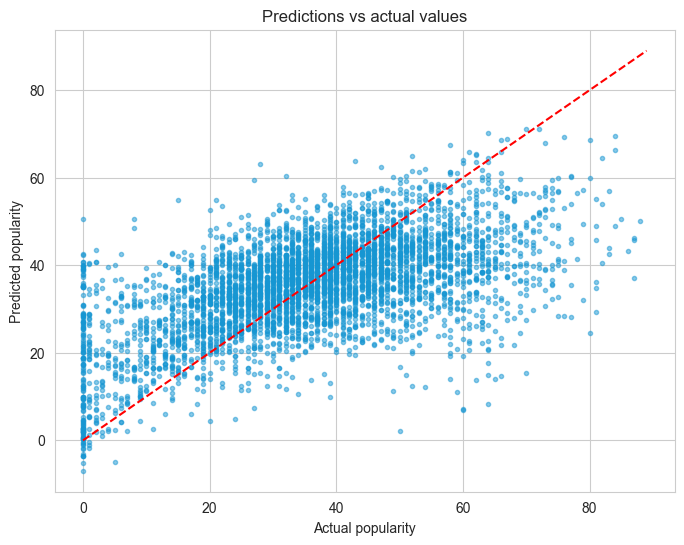

In [8]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('data/spotify_data.csv')
df.dropna(subset=['genres'], inplace=True)
df['genres'] = df['genres'].apply(ast.literal_eval)
mlb = MultiLabelBinarizer(sparse_output=True)
df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('genres')),
                index=df.index,
                columns=mlb.classes_))

X = df.drop(columns=['popularity']).copy()
y = df['popularity']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

numerical_variables = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_variables = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_variables),
    ('cat', categorical_pipeline, categorical_variables)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Metrics
print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 score: {r2_score(y_test, y_pred):.2f}")
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#1696d2', alpha=0.5, marker='.')
plt.plot([0, 89], [0, 89], color='red', linestyle='--')
plt.xlabel('Actual popularity')
plt.ylabel('Predicted popularity')
plt.title('Predictions vs actual values')
plt.show()

In [ ]:
from sklearn.linear_model import ElasticNet

# ElasticNet param grid
params_grid = {
    'regressor__alpha': [0.1, 0.5, 1],
    'regressor__l1_ratio': [0.1, 0.5, 1]
}

# Define KFold cross-validation
kf = KFold(n_splits=5)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(random_state=42))
])

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=params_grid,
    cv=kf,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

# Metrics
y_pred = grid_search.predict(X_test)
print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 score: {r2_score(y_test, y_pred):.2f}")
# Save model
joblib.dump(grid_search.best_estimator_, 'models/elasticnet_pipeline.pkl')

C:\Users\joaob\PycharmProjects\SCC5948_Ver4_Turma3_2024\.venv\lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\joaob\PycharmProjects\SCC5948_Ver4_Turma3_2024\.venv\lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\joaob\PycharmProjects\SCC5948_Ver4_Turma3_2024\.venv\lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Mean squared error: 188.71
R2 score: 0.34


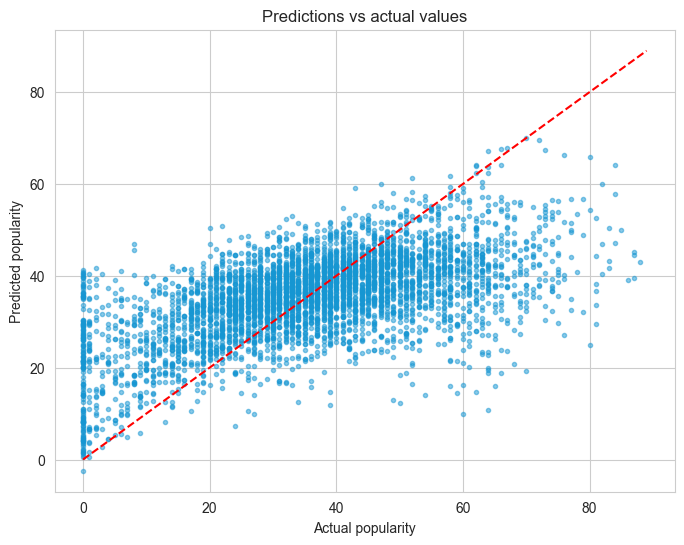

In [9]:
# Load model
pipeline = joblib.load('models/elasticnet_pipeline.pkl')

pipeline.fit(X_train, y_train)

# Metrics
y_pred = pipeline.predict(X_test)
print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 score: {r2_score(y_test, y_pred):.2f}")
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='#1696d2', alpha=0.5, marker='.')
plt.plot([0, 89], [0, 89], color='red', linestyle='--')
plt.xlabel('Actual popularity')
plt.ylabel('Predicted popularity')
plt.title('Predictions vs actual values')
plt.show()